# 🌸 Klasifikasi Gambar Bunga dengan CNN (TensorFlow)

**Penjelasan:** Notebook ini mengikuti instruksi dari studi kasus klasifikasi gambar bunga menggunakan model Deep Learning (CNN) di TensorFlow. Proyek ini meliputi eksplorasi dataset, preprocessing, pembuatan model CNN, evaluasi metrik (akurasi, f1, precision, confusion matrix), dan prediksi gambar baru.

Dataset: TensorFlow Flowers (https://www.tensorflow.org/datasets/catalog/tf_flowers)

Framework: TensorFlow + Keras

In [7]:
# ============================
# 🔁 STEP 0: Import Library
# ============================
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

Kelas bunga: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Total gambar: 3670


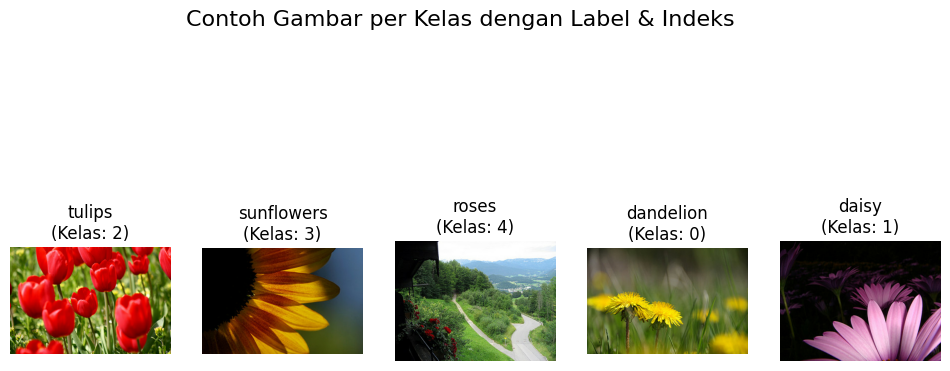

In [8]:
# ============================
# 👁️ STEP 1: Eksplorasi Dataset
# ============================

# Load dataset
dataset, info = tfds.load('tf_flowers', split='train', as_supervised=True, with_info=True)

# Lihat label/kategori bunga
class_names = info.features['label'].names
print("Kelas bunga:", class_names)
print("Total gambar:", info.splits['train'].num_examples)

# Tampilkan 1 gambar dari tiap kelas beserta nama dan indeks kelas
plt.figure(figsize=(12, 6))
shown_classes = set()
i = 0
for image, label in dataset:
    label_index = label.numpy()
    label_name = class_names[label_index]
    if label_name not in shown_classes:
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(f"{label_name}\n(Kelas: {label_index})")
        plt.axis("off")
        shown_classes.add(label_name)
        i += 1
    if len(shown_classes) == 5:
        break
plt.suptitle("Contoh Gambar per Kelas dengan Label & Indeks", fontsize=16)
plt.show()

In [9]:
# ============================================
# 🧹 STEP 2: Menerapkan Preprocessing Data
# ============================================

# Ukuran gambar & batch
IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Fungsi resize & normalisasi
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize ke 128x128 piksel
    image = tf.cast(image, tf.float32) / 255.0            # Normalisasi pixel 0-1
    return image, label

# Augmentasi gambar
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),     # Membalik horizontal
    tf.keras.layers.RandomRotation(0.2),          # Rotasi acak
    tf.keras.layers.RandomZoom(0.1)               # Zoom acak
])

# Split dataset: 80% train, 20% test
total = info.splits['train'].num_examples
train_size = int(0.8 * total)
ds_train = dataset.take(train_size)
ds_test = dataset.skip(train_size)

# Terapkan preprocessing
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

# Terapkan augmentasi hanya ke data train
ds_train = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Shuffle dan batching
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [10]:
# =============================================
# 🧠 STEP 3: Mengimplementasikan CNN
# =============================================

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # Layer Conv1
    tf.keras.layers.MaxPooling2D(2,2),                                                         # Pooling1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                                      # Conv2
    tf.keras.layers.MaxPooling2D(2,2),                                                         # Pooling2
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),                                     # Conv3
    tf.keras.layers.MaxPooling2D(2,2),                                                         # Pooling3
    tf.keras.layers.Flatten(),                                                                 # Flatten
    tf.keras.layers.Dense(128, activation='relu'),                                             # Dense
    tf.keras.layers.Dense(5, activation='softmax')                                             # Output layer (5 kelas bunga)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# =============================================
# 🔁 STEP 4: Training Model
# =============================================
history = model.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3627 - loss: 1.4252 - val_accuracy: 0.5163 - val_loss: 1.1081
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5567 - loss: 1.1048 - val_accuracy: 0.5790 - val_loss: 1.0466
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6315 - loss: 0.9603 - val_accuracy: 0.6485 - val_loss: 0.8801
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6380 - loss: 0.8908 - val_accuracy: 0.6894 - val_loss: 0.8163
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6775 - loss: 0.8403 - val_accuracy: 0.6594 - val_loss: 0.8301
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7113 - loss: 0.7829 - val_accuracy: 0.7125 - val_loss: 0.7652
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7114 - loss: 0.7695 - val_accuracy: 0.7003 - val_loss: 0.7614
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7173 - loss: 0.7418 - val_accuracy: 0.6935 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
=== Classification Report ===
              precision    recall  f1-score   support

   dandelion      

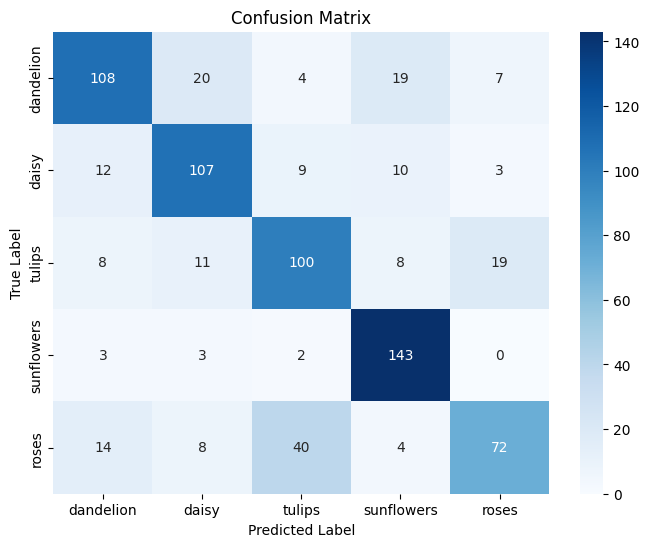

In [12]:
# =============================================
# 📈 STEP 5: Evaluasi Model
# =============================================

# Prediksi data test
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (dengan annot=True)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Saving daisy.jpg to daisy (4).jpg
Saving dandelion.jpg to dandelion (1).jpg
Saving roses.webp to roses (1).webp
Saving sunflowers.jpg to sunflowers (2).jpg
Saving tulip.jpeg to tulip (1).jpeg

🔍 Memprediksi gambar: daisy (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Model memprediksi gambar ini sebagai 'daisy' dengan keyakinan 100.00%


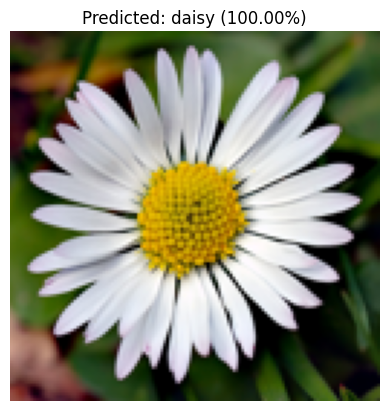


🔍 Memprediksi gambar: dandelion (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Model memprediksi gambar ini sebagai 'dandelion' dengan keyakinan 88.36%


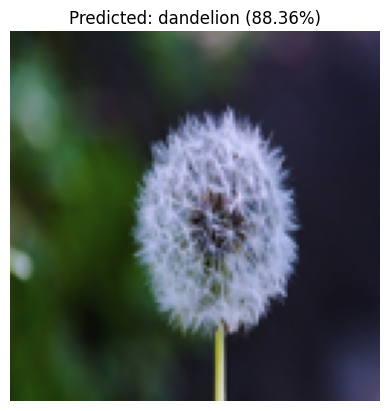


🔍 Memprediksi gambar: roses (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Model memprediksi gambar ini sebagai 'roses' dengan keyakinan 77.73%


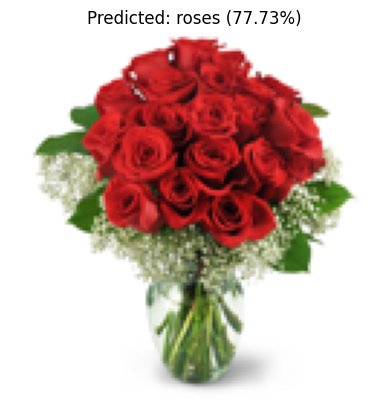


🔍 Memprediksi gambar: sunflowers (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Model memprediksi gambar ini sebagai 'sunflowers' dengan keyakinan 99.80%


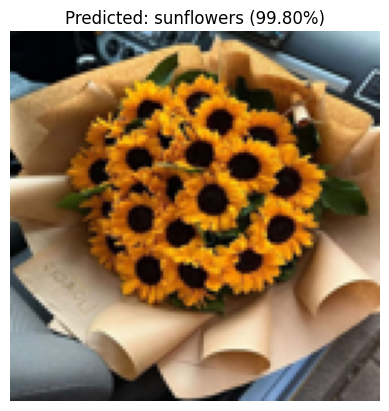


🔍 Memprediksi gambar: tulip (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Model memprediksi gambar ini sebagai 'tulips' dengan keyakinan 99.91%


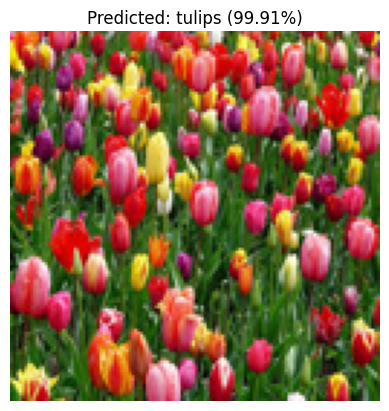

In [40]:
# =============================================
# 🔍 STEP 6: Uji Gambar Baru
# =============================================

# Fungsi prediksi gambar baru
def predict_new_image(image_path):
    img = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))         # Resize gambar
    img_array = np.array(img) / 255.0                                 # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)                     # Tambah batch dimension
    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    print(f"Model memprediksi gambar ini sebagai '{pred_class}' dengan keyakinan {confidence:.2f}%")
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Upload gambar dari lokal
from google.colab import files
uploaded = files.upload()

# Loop untuk memproses dan memprediksi semua gambar yang di-upload
for image_path in uploaded.keys():
    print(f"\n🔍 Memprediksi gambar: {image_path}")
    predict_new_image(image_path)